# 📈 Building a Portfolio Using the Efficient Frontier

**Author:** Kuo Liang
**Date:** October 2025  

---

![Efficient Frontier Cover](images/efficient_frontier.png)

---

## 🧩 Introduction

This notebook demonstrates how to construct an optimized investment portfolio using **Modern Portfolio Theory (MPT)** and the **Efficient Frontier** approach.  

The Efficient Frontier represents a set of portfolios that provide the **maximum expected return for a given level of risk** or the **minimum risk for a given level of return**. By simulating thousands of portfolios with different asset weight combinations, we can visualize and identify the most efficient allocation.

---

## 🧠 Notebook Overview

The notebook is organized into the following sections:

1. **Data Gathering** — Collect historical stock price data for a set of assets.  
2. **Data Processing** — Compute returns, risk (standard deviation), and correlation metrics.  
3. **Monte Carlo Simulation** — Generate random portfolio weights and calculate performance metrics (return, volatility, Sharpe ratio).  
4. **Data Visualization** — Plot the simulated portfolios and highlight the Efficient Frontier, including optimal portfolios such as:

---

## 🛠️ Tools & Libraries
- `pandas`, `numpy` — Data manipulation and numerical computation  
- `plotly` — Visualization  
- `yfinance` — Historical stock price data retrieval
- `tqdm` — Progess bar
- `rich` — Beautify console output  

---

> 💡 **Goal:** Learn how to apply mathematical and statistical methods to construct a data-driven investment portfolio that balances risk and return.


## 1. **Data Gathering** 

In [57]:
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from rich.traceback import install
from tqdm.notebook import tqdm
import yfinance as yf

install()
pd.set_option('display.max_columns', None)

In [14]:
# gather some tickers
ticker_df = pd.read_csv('data/tickers_10_sectors.csv')

# fetch all tickers to download
all_tickers = pd.melt(ticker_df,id_vars=['Sector'],value_name='Ticker')['Ticker'].unique().tolist()

# download & only use the Adj Close prices
data = yf.download(all_tickers, start='2020-01-01', auto_adjust=False) # download from 

close_prices = data.dropna(axis=1, how='any')['Adj Close'].copy()

avaliable_tickers = close_prices.columns.tolist()

[*********************100%***********************]  110 of 110 completed

2 Failed downloads:
['ATVI', 'BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


**Let's select 10 tickers and plot the _`normalized`_ performance over time**

In [32]:
seed = 42
random.seed(seed)

select_tickers = random.sample(avaliable_tickers, 10)
to_exam = close_prices[select_tickers]

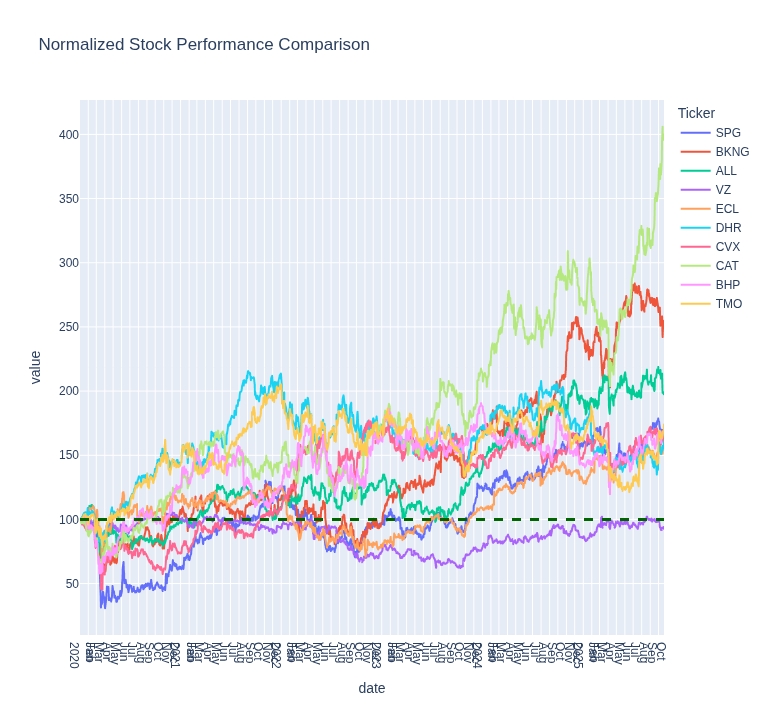

In [33]:
df = to_exam / to_exam.iloc[0] * 100
df['date'] = df.index

fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='Normalized Stock Performance Comparison',  width=1200, height=700)

fig.add_hline(y=100, line_width=3, line_color='darkgreen', line_dash='dash')

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.show()

## 2. **Data Processing** 

<Axes: xlabel='Date'>

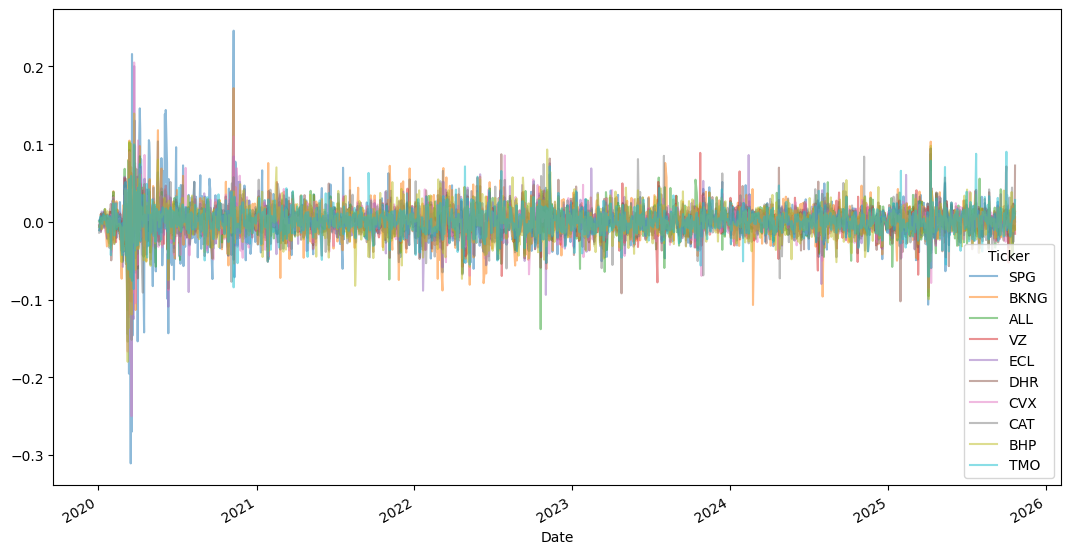

In [99]:
log_returns = np.log(to_exam / to_exam.shift(1))
log_returns.plot(figsize=(13,7), alpha=0.5)

## 3. **Monte Carlo Simulation** 

Run 3000 simulations

In [44]:
num_simulation = 3000 # let'run it 3000 times

# create return and volatility array as the columns 
num_assets = len(select_tickers)
pfolio_returns = []
pfolio_volatilities = []

w_lst = []

# append columns for each stock to the DataFrame
for i in range(num_assets):
    w_lst.append([])

# Followig generate the simulation
for x in tqdm(range(num_simulation)):
    # random weights for all stocks
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    for i in range(num_assets):
        w_lst[i].append(weights[i])

    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 250, weights))))
    
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

for i in range(num_assets):
    w_lst[i] = np.array(w_lst[i])

# pfolio_returns, pfolio_volatilities, w_lst[0], w_lst[1], w_lst[2]

  0%|          | 0/3000 [00:00<?, ?it/s]

Take the result and make into a dataframe

In [45]:
# build simulated portfolios.
df_build = {'Return': pfolio_returns, 'Volatility': pfolio_volatilities}
for w in range(num_assets):
    df_build[select_tickers[w]] = w_lst[w]
portfolios = pd.DataFrame(df_build)

portfolios['row_index'] = portfolios.index

portfolios.head(2)

,Return,Volatility,SPG,BKNG,ALL,VZ,ECL,DHR,CVX,CAT,BHP,TMO,row_index
0,0.121245,0.233842,0.118475,0.174268,0.021450,0.060054,0.030142,0.163189,0.102703,0.170815,0.074029,0.084875,0
1,0.120285,0.231841,0.168325,0.044773,0.156495,0.051311,0.037058,0.016027,0.040998,0.186583,0.100407,0.198023,1


## 4. **Data Visualization** 

**Hover over the point to see the row index, which will then be used to assign propoertion**

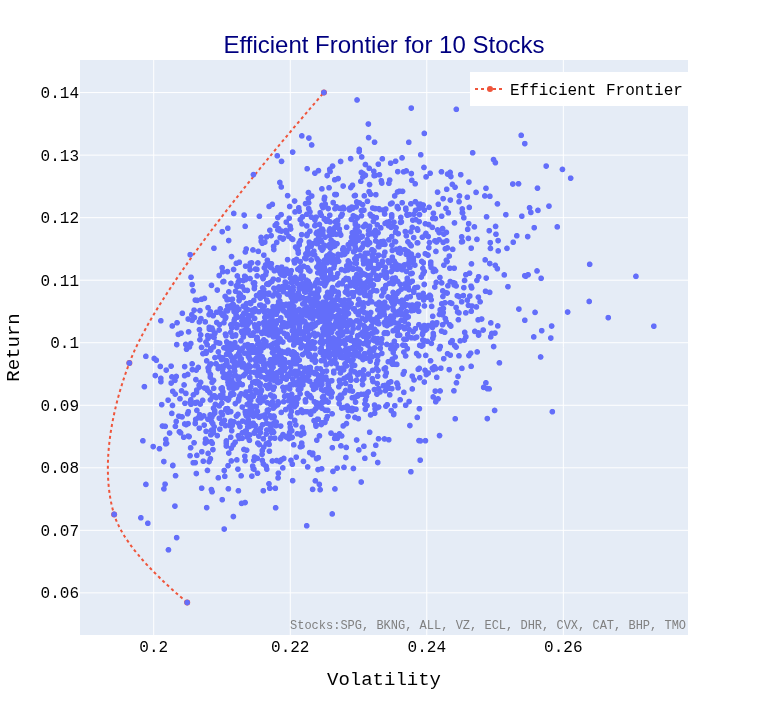

In [97]:
# make the line for Eff. Frontier
num_on_left = 2 # play with this number to get a better lines

first_index = portfolios['Return'].idxmin()
second_index = portfolios['Volatility'].sort_values().head(num_on_left).index.values.tolist()
third_index = portfolios['Return'].idxmax()
eff_front_df = portfolios.loc[[first_index] + second_index + [third_index]]

# use plotly for the plotting
fig = px.scatter(portfolios, x='Volatility', y='Return', hover_data=['row_index'])

fig.add_trace(
    go.Scatter(
        x=eff_front_df['Volatility'],
        y=eff_front_df['Return'],
        mode='lines+markers',
        name='Efficient Frontier',
        customdata=eff_front_df['row_index'],
        hovertemplate="row index:%{customdata}<br> Volatility:%{x}<br>Return:%{y}",
        line=dict(width=2, shape='spline', dash='dot')#smoothing=1)
    )
)

fig.update_layout(
    title=dict(
        text="Efficient Frontier for 10 Stocks",
        font=dict(size=24, color="navy", family="Arial"),
        x=0.5,
        y=0.95,
        xanchor="center",
        yanchor="top"
    ),
    font=dict(
        family="Courier New, monospace",
        size=16,
        color="black"
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.92,
        xanchor='right',
        x=1
    ),
    width=1000,
    height=700,
    xaxis=dict(
        title="Volatility",
    ),
    yaxis=dict(
        title="Return",
    ),
    annotations=[
        dict(
            text=f"Stocks:{', '.join(select_tickers)}",
            x=1, y=0, xref='paper', yref='paper',
            xanchor='right', yanchor='bottom', showarrow=False,
            font=dict(size=12, color='gray')
        )
    ]
)

fig.show()

**I want to choose the 3rd portfolio on the frontier from bottom, and the index is 2997  
I intend to invest`$10,000` in the portfolio, and here is how many shares I would buy  
for each stock. Note that I will buy *`fractional`* shares which many trading platforms support.**

In [94]:
invest_amount = 10_000
print(f'Selected Portfolio Valitality:{portfolios.loc[2997]['Volatility']:,.4f} and Return: {portfolios.loc[2997]['Return']:,.4f}')
for tick in select_tickers:
    prop = portfolios.loc[2997][tick]
    last_price = to_exam.iloc[-1][tick]
    money_to_invest = round(invest_amount * prop, 2)  # round to the nearst cent
    shares = round(money_to_invest / last_price, 4)  # round to 4 decimal
    print(f"{tick}:\n\tInvest: ${money_to_invest}\n\tNumber of Shares: {shares}")

Selected Portfolio Valitality:0.1964 and Return: 0.0968
SPG:
	Invest: $19.33
	Number of Shares: 0.1071
BKNG:
	Invest: $936.65
	Number of Shares: 0.1797
ALL:
	Invest: $1878.0
	Number of Shares: 9.6365
VZ:
	Invest: $2068.2
	Number of Shares: 51.4798
ECL:
	Invest: $601.67
	Number of Shares: 2.1473
DHR:
	Invest: $2048.26
	Number of Shares: 9.143
CVX:
	Invest: $190.65
	Number of Shares: 1.238
CAT:
	Invest: $1165.01
	Number of Shares: 2.1919
BHP:
	Invest: $253.62
	Number of Shares: 4.51
TMO:
	Invest: $838.62
	Number of Shares: 1.4993
